# Beamforming algorithm selection
Compares the performance of different beamforming algorithms, via:

- SIR for two sources place a fixed distance apart (averaged across the entire stage)

In [27]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound

Simulation parameters

In [28]:
# ROOM PARAMETERS

fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 12 # room width
room_y = 20 # room length
stage_x = [1, 11]
stage_y = [12, 18] # x/y bounds of stage in the room
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
source_step = 1 # resolution of simulation grid (m)

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption when order is nonzero

# MIC ARRAY PARAMETERS
array_loc = [6, 10] # x/y location of array - front and center of stage
n_mics = 8 # number of microphones
sep = 0.1 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, fs, N) # uses omnidirectional mics by default

# SOUND SOURCE PARAMETERS
source_x = np.arange(stage_x[0], stage_x[1]+source_step, source_step)
source_y = np.arange(stage_y[0], stage_y[1]+source_step, source_step) # Define spatial grid over which to simulate
source_filenames = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav']
_, singing = wavfile.read(source_filenames[0])
_, speech = wavfile.read(source_filenames[1])

### Run Simulations

Sources are placed d metres apart, at the same distance from the array.

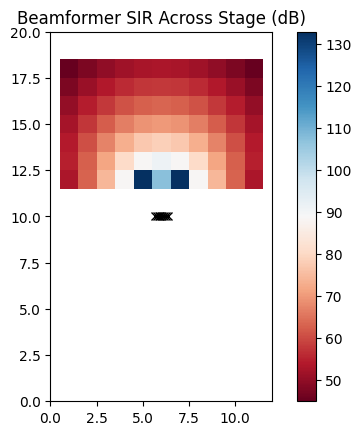

Average SIR across stage (dB):  64.0969764715092
Maximum SIR across stage (dB):  132.8964466798973
Minimum SIR across stage (dB):  44.93279054900001


In [40]:
SIRs = np.empty(shape=(len(source_x),len(source_y)))
d = 1 # source separation parameter

for i in range(len(source_x)):
    for j in range(len(source_y)):

        x = source_x[i]
        y = source_y[j]

        # build room, array, and sources
        room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)
        room.add_microphone_array(mic_array)

        s1 = [x, y] # 1st source location
        s1_mic = [x - array_loc[0], y - array_loc[1]] # location relative to array
        r = math.sqrt(s1_mic[0]**2 + s1_mic[1]**2)
        phi_rad = 2 * math.asin(d/(2*r))

        if s1_mic[0] < 0:
            phi_rad *= -1

        s2_mic = [s1_mic[0]*math.cos(phi_rad) - s1_mic[1]*math.sin(phi_rad), s1_mic[0]*math.sin(phi_rad) + s1_mic[1]*math.cos(phi_rad)] # 2nd source location relative to array
        s2 = [s2_mic[0] + array_loc[0], s2_mic[1] + array_loc[1]]

        source_locs = [s1, s2] # locations of each source
        room.add_source(source_locs[0], signal=singing, delay=0)
        room.add_source(source_locs[1], signal=speech, delay=0)

        # define beamformer algorithm and compute weights
        mic_array.rake_one_forcing_weights(
            source=room.sources[0][0:1],
            interferer=room.sources[1][0:1],
            R_n=sigma2_n * np.eye(mic_array.M)
        )
        mic_array.filters_from_weights()

        # run simulation
        room.compute_rir()
        room.simulate()

        # compute SIR
        SIRs[i, j] = mic_array.snr(room.sources[0][0:1], room.sources[1][0:1], 1000, dB=True)

# plot SIR as a function of location
y, x = np.meshgrid(source_y, source_x)
sir_min = np.min(SIRs)
sir_max = np.max(SIRs)
sir_avg = np.mean(SIRs)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, SIRs, cmap='RdBu', vmin=sir_min, vmax=sir_max)
ax.plot(mic_array.R[0], mic_array.R[1], 'kx')
ax.set_title('Beamformer SIR Across Stage (dB)')
ax.axis([0, room_x, 0, room_y])
fig.gca().set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax)
plt.show()

# output SIR stats
print("Average SIR across stage (dB): ", sir_avg)
print("Maximum SIR across stage (dB): ", sir_max)
print("Minimum SIR across stage (dB): ", sir_min)